In [333]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.base import ClusterMixin
from sklearn.base import BaseEstimator
sns.set(rc={'figure.figsize':(11.7,8.27)})
from random import *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist

In [334]:
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca



In [335]:
def add_labels(x, y, labels, ax=None):
    """Ajoute les étiquettes `labels` aux endroits définis par `x` et `y`."""

    if ax is None:
        ax = plt.gca()
    for x, y, label in zip(x, y, labels):
        ax.annotate(
            label, [x, y], xytext=(10, -5), textcoords="offset points",
        )

    return ax

In [336]:
race = pd.read_csv("../../../output/data_clean/cleaned_race_2.csv", index_col= 0)
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col= 0)

race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133 entries, 0 to 1206
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   race_year_id          1133 non-null   int64  
 1   event                 1133 non-null   object 
 2   race                  1133 non-null   object 
 3   country               1133 non-null   object 
 4   participation         1133 non-null   object 
 5   distance              1133 non-null   float64
 6   elevation_gain        1133 non-null   float64
 7   elevation_loss        1133 non-null   float64
 8   aid_stations          1133 non-null   int64  
 9   participants          1133 non-null   int64  
 10  year                  1133 non-null   int64  
 11  month                 1133 non-null   int64  
 12  day                   1133 non-null   int64  
 13  frequency_in_ranking  1133 non-null   int64  
dtypes: float64(3), int64(7), object(4)
memory usage: 132.8+ KB


In [337]:
race = race.loc[race.distance >= 150]
#race = race.loc[race.give_up != 0]

In [338]:
race = race.assign(
    give_up = race.participants - race.frequency_in_ranking
)

In [339]:
#race = race.drop_duplicates(subset=['event','race'], keep='last')

<AxesSubplot:xlabel='difficulty', ylabel='Count'>

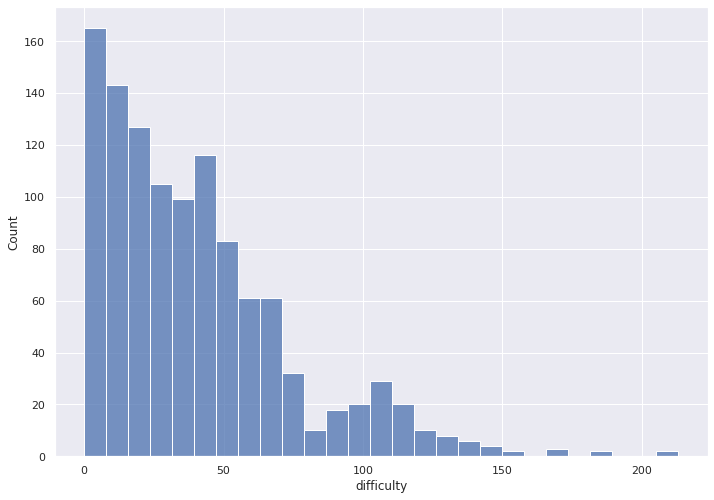

In [340]:
race = race.assign(
    difficulty = (race.distance + race.elevation_gain)**2 / 1000000
)
sns.histplot(race.difficulty)

In [341]:
ratio = race.distance 

<AxesSubplot:xlabel='axis1', ylabel='axis2'>

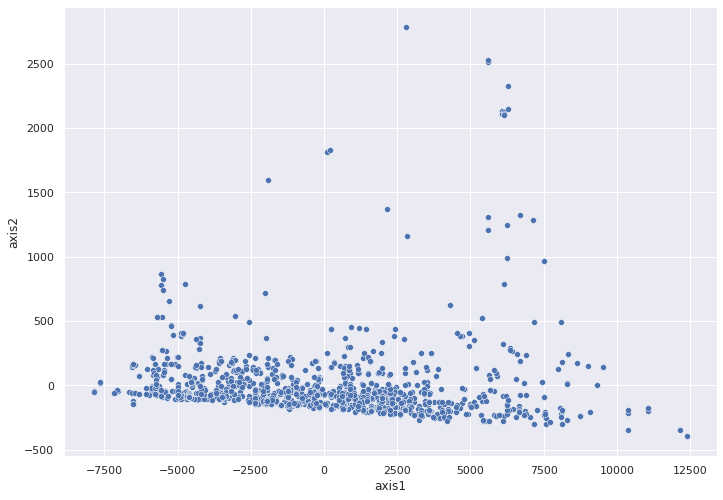

In [342]:
df = race[["distance","elevation_gain","elevation_loss","participants","aid_stations", "give_up"]]

cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
#X = pd.concat([X, join.age_range], axis=1)


sns.scatterplot(x = "axis1", y = "axis2",data = X)

In [343]:
cls.components_

array([[ 3.52420845e-04,  7.03069792e-01, -7.10921527e-01,
         1.67171390e-02,  9.62691962e-06,  1.96566573e-03],
       [ 7.88436452e-04, -5.10473822e-02, -2.74055711e-02,
         9.42817344e-01,  4.86133199e-03,  3.28198570e-01],
       [ 1.58597136e-04,  7.08397954e-01,  7.02094701e-01,
         6.76691759e-02, -1.73168936e-03, -2.55583445e-02],
       [-7.75693430e-04,  3.54683106e-02,  3.00227124e-02,
        -3.25935433e-01,  9.42580248e-03,  9.44201929e-01],
       [ 7.78203916e-02,  1.10767370e-03,  1.08402667e-03,
        -1.46878938e-03,  9.96910117e-01, -1.04711461e-02]])

In [344]:
cls.explained_variance_ratio_

array([9.88976611e-01, 7.04273595e-03, 2.97679946e-03, 9.98812803e-04,
       3.84579177e-06])

In [345]:
race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1126 entries, 0 to 1206
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   race_year_id          1126 non-null   int64  
 1   event                 1126 non-null   object 
 2   race                  1126 non-null   object 
 3   country               1126 non-null   object 
 4   participation         1126 non-null   object 
 5   distance              1126 non-null   float64
 6   elevation_gain        1126 non-null   float64
 7   elevation_loss        1126 non-null   float64
 8   aid_stations          1126 non-null   int64  
 9   participants          1126 non-null   int64  
 10  year                  1126 non-null   int64  
 11  month                 1126 non-null   int64  
 12  day                   1126 non-null   int64  
 13  frequency_in_ranking  1126 non-null   int64  
 14  give_up               1126 non-null   int64  
 15  difficulty           

In [346]:
racequant = race[['distance','elevation_gain','elevation_loss','elevation_gain','aid_stations','difficulty']]
racequant

,distance,elevation_gain,elevation_loss,elevation_gain,aid_stations,difficulty
0,166.9,4520.0,-4520.0,4520.0,10,21.967032
1,170.7,9930.0,-9930.0,9930.0,11,102.024140
2,167.0,9980.0,-9980.0,9980.0,13,102.961609
3,164.0,7490.0,-7500.0,7490.0,13,58.583716
4,159.9,100.0,-100.0,100.0,12,0.067548
...,...,...,...,...,...,...
1202,161.0,1600.0,-1600.0,1600.0,0,3.101121
1203,161.0,4000.0,-4000.0,4000.0,0,17.313921
1204,161.0,2400.0,-2400.0,2400.0,0,6.558721
1205,161.0,1800.0,-1800.0,1800.0,0,3.845521


In [347]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
X = pd.DataFrame(
    squareform(pdist(racequant)),
    columns = race.race_year_id,
    index = race.race_year_id
)

In [348]:
X

race_year_id,68140,72496,69855,67856,70469,66887,67851,68241,70241,69945,...,4164,3433,3305,3453,3601,2320,3439,5640,3202,3253
race_year_id,,,,,,,,,,,,,,,,,,,,,
68140,0.000000,9370.737675,9457.344719,5150.102736,7655.699353,9232.166273,1628.167045,209.318009,3178.540819,2459.574613,...,3585.395979,381.233630,1593.548240,6027.713255,4468.813332,5057.636872,900.753274,3671.998397,4711.227356,5369.508636
72496,9370.737675,0.000000,86.709681,4220.667715,17026.368162,139.053854,7742.592547,9162.925460,6196.814452,11830.268041,...,12956.098156,9751.802878,10964.243604,3343.077897,4901.975888,14428.329801,10271.421076,13042.700209,14081.922956,4001.279257
69855,9457.344719,86.709681,0.000000,4307.270411,17112.972816,225.304343,7829.199375,9249.531417,6283.394225,11916.871737,...,13042.704809,9838.409635,11050.850346,3429.683225,4988.581308,14514.936346,10358.027830,13129.306856,14168.529528,4087.885059
67856,5150.102736,4220.667715,4307.270411,0.000000,12805.765965,4082.089240,3521.958361,4942.276047,1980.066715,7609.638465,...,8735.476962,5531.172967,6743.615706,877.748422,681.483330,10207.715529,6050.791783,8822.079381,9861.306925,219.958729
70469,7655.699353,17026.368162,17112.972816,12805.765965,0.000000,16887.792488,9283.849429,7863.584237,10832.066199,5196.176235,...,4070.342832,7274.650408,6062.206149,13683.368446,12124.475864,2598.105928,6755.030914,3983.740371,2944.513454,13025.168045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,5057.636872,14428.329801,14514.936346,10207.715529,2598.105928,14289.756962,6685.779429,5265.535836,8234.292766,2598.190390,...,1472.247877,4676.567354,3464.119220,11085.307048,9526.408652,0.000000,4156.946235,1385.644960,346.410961,10427.104089
3439,900.753274,10271.421076,10358.027830,6050.791783,6755.030914,10132.847379,2528.841179,1108.830254,4078.558684,1559.031967,...,2684.699272,519.621680,692.827570,6928.378548,5369.474249,4156.946235,0.000000,2771.302162,3810.535579,6270.172951
5640,3671.998397,13042.700209,13129.306856,8822.079381,3983.740371,12904.127035,5300.137853,3879.915220,6848.891324,1212.663615,...,86.602926,3290.923579,2078.474814,9699.670365,8140.769664,1385.644960,2771.302162,0.000000,1039.234026,9041.466386


In [349]:
n,p = X.shape
Qn = np.eye(n) - 1/n * np.ones((n,n),dtype=int)
Qp = np.eye(p) - 1/p * np.ones((p,p),dtype=int)

Xprime = Qn @ X @ Qp
Xprime

,0,1,2,3,4,5,6,7,8,9,...,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125
0,-2779.275120,2900.193604,2913.387223,1747.026407,-790.808420,2878.214592,-904.175372,-2518.657300,526.896720,-1429.667606,...,-1074.608176,-2507.393557,-1807.892277,2102.773850,1402.752875,-846.213438,-2183.316862,-1053.668945,-879.717904,1844.767797
1,2900.193604,-10161.813023,-10148.516766,-2873.677565,4888.591438,-9906.166778,1518.981178,2743.681199,-146.098599,4249.756870,...,4604.825050,3171.906741,3871.534136,-4273.130460,-1855.353520,4833.210539,3496.081988,4625.763916,4799.708744,-3214.730533
2,2913.387223,-10148.516766,-10308.639871,-2860.488293,4901.782668,-9893.329713,1532.174582,2756.873732,-132.932250,4262.947143,...,4618.018278,3185.100073,3884.727454,-4259.938555,-1842.161524,4846.403660,3509.275318,4638.957139,4812.901893,-3201.538155
3,1747.026407,-2873.677565,-2860.488293,-4026.877537,3735.456984,-2895.663649,365.814735,1590.499529,-1295.378593,3096.595037,...,3451.671599,2018.744572,2718.373980,-3670.992192,-3008.378335,3680.064010,2342.920438,3472.610830,3646.560457,-3928.583318
4,-790.808420,4888.591438,4901.782668,3735.456984,-14113.740426,4866.608155,1084.274359,-531.623726,2513.189447,-4360.298637,...,-6256.893976,-1281.209431,-3006.467021,4091.196388,3391.182755,-8972.977035,-1996.271875,-6409.159623,-8313.664458,3833.194554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,-846.213438,4833.210539,4846.403660,3680.064010,-8972.977035,4811.230091,1028.861821,-587.014664,2458.073477,-4415.627020,...,-6312.331468,-1336.635022,-3061.896487,4035.792453,3335.773005,-9028.425501,-2051.699091,-6464.597572,-8369.109489,3777.788060
1122,-2183.316862,3496.081988,3509.275318,2342.920438,-1996.271875,3474.100682,-308.296255,-1923.940072,1122.119568,-2635.005268,...,-2280.099899,-2673.800522,-3013.407963,2698.644127,1998.618776,-2051.699091,-3388.865152,-2259.160196,-2085.204697,2440.637096
1123,-1053.668945,4625.763916,4638.957139,3472.610830,-6409.159623,4603.783133,821.403214,-794.452311,2250.855003,-4622.970826,...,-6519.793450,-1544.095829,-3269.357924,3828.338738,3128.316986,-6464.597572,-2259.160196,-6672.059563,-6498.103455,3570.333326
1124,-879.717904,4799.708744,4812.901893,3646.560457,-8313.664458,4777.728208,995.356864,-620.515588,2424.620743,-4449.116939,...,-6345.837347,-1370.140543,-3095.402190,4002.288833,3302.268777,-8369.109489,-2085.204697,-6498.103455,-8402.615400,3744.284172


/home/romain/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

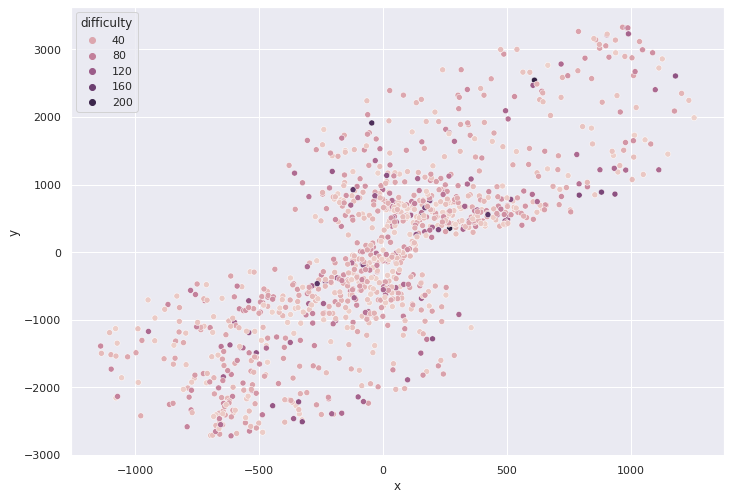

In [350]:
aftd = MDS(n_components=2, dissimilarity='precomputed')
dist = aftd.fit_transform(Xprime)

df = pd.DataFrame({"x": dist[:, 0], "y": dist[:, 1]})
df = df.assign(
    country = race.country,
    participants = race.participants,
    difficulty = race.difficulty,
    frequency = race.frequency_in_ranking,
    distance = race.distance,
    participation = race.participation
    
)

sns.scatterplot("x", "y", hue = "difficulty",data=df)

# Classification ascendante hiérarchique

In [351]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

In [352]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})

    dendrogram(linkage_matrix, **default_kwargs)


In [353]:
cls = AgglomerativeClustering(linkage="ward", affinity="euclidean", distance_threshold=0, n_clusters=None)
cls.fit(racequant)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

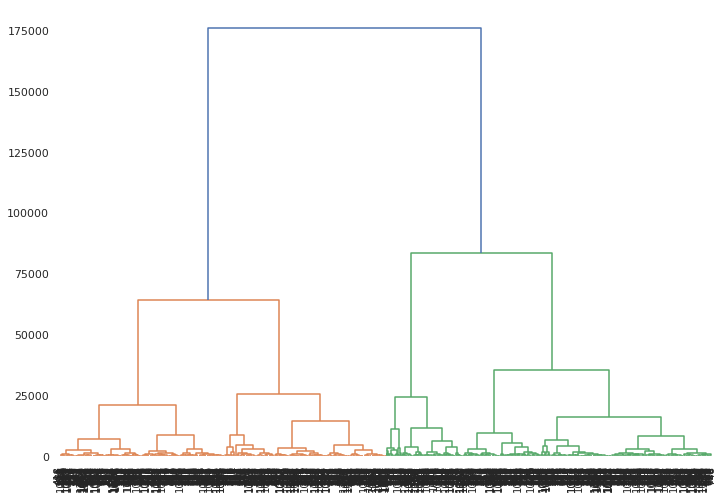

In [354]:
plot_dendrogram(cls)

In [363]:
elevation_diff = race.elevation_gain + race.elevation_loss

<AxesSubplot:ylabel='Count'>

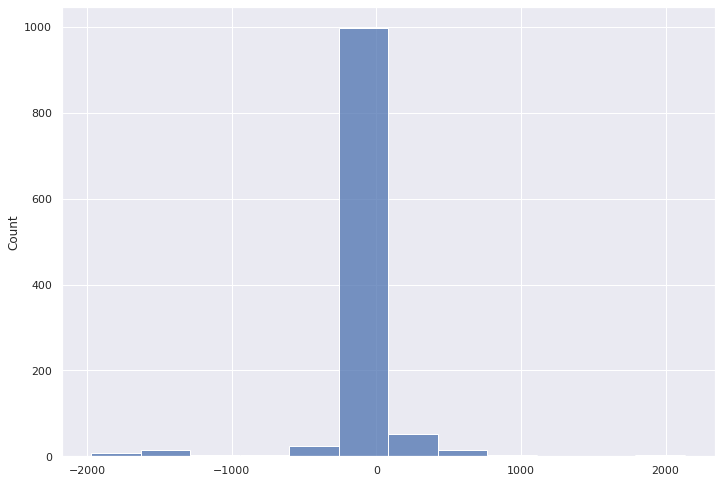

In [364]:
sns.histplot(elevation_diff)

/home/romain/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

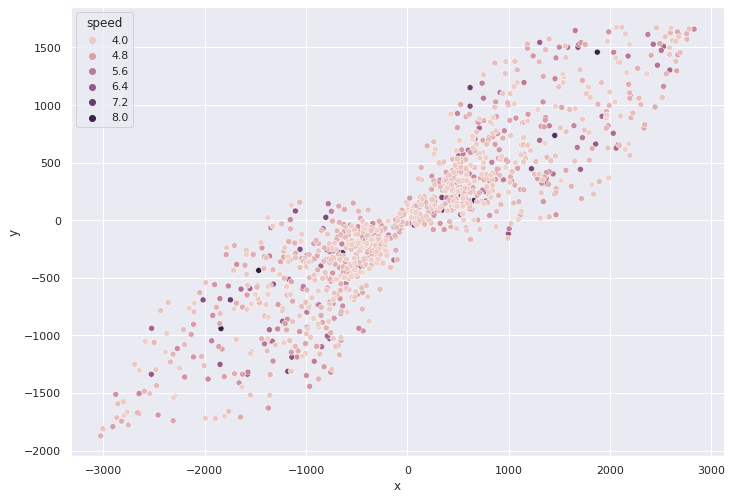

In [380]:
model = AgglomerativeClustering(
    affinity="precomputed", linkage="complete", n_clusters=3
).fit(Xprime)

labels = model.labels_

aftd = MDS(n_components=2, dissimilarity="precomputed")
dist = aftd.fit_transform(Xprime)

df = pd.DataFrame({"x": dist[:, 0], "y": dist[:, 1], "étiquette":labels})

df = df.assign(
    distance = race.distance,
    participants = race.participants,
    speed = join.speed
)

sns.scatterplot("x", "y", hue="speed", data=df)
#add_labels(dist[:, 0], dist[:, 1], X.index)

Rajouter l'étiquette au df et recommencer analyse explo( ACP avec hue=etiquette)

In [262]:
racequant = race[['distance','elevation_gain','aid_stations','participants','frequency_in_ranking','country','participation']]
l_eg = race['elevation_gain']
racequant = racequant.drop('elevation_gain', axis = 1)


# ONE HOT ENCODING


one_hot_country = pd.get_dummies(race['country'], prefix = "country")
one_hot_participation = pd.get_dummies(race['participation'], prefix = "participation")
# Drop column B as it is now encoded
racequant = racequant.drop('country',axis = 1)
racequant = racequant.drop('participation',axis = 1)
# Join the encoded df
racequant = racequant.join(one_hot_country)
racequant = racequant.join(one_hot_participation)
racequant = racequant.div(l_eg, axis = 0)
racequant
racequant = racequant.apply(lambda x: x-x.mean())

<AxesSubplot:xlabel='axis1', ylabel='axis2'>

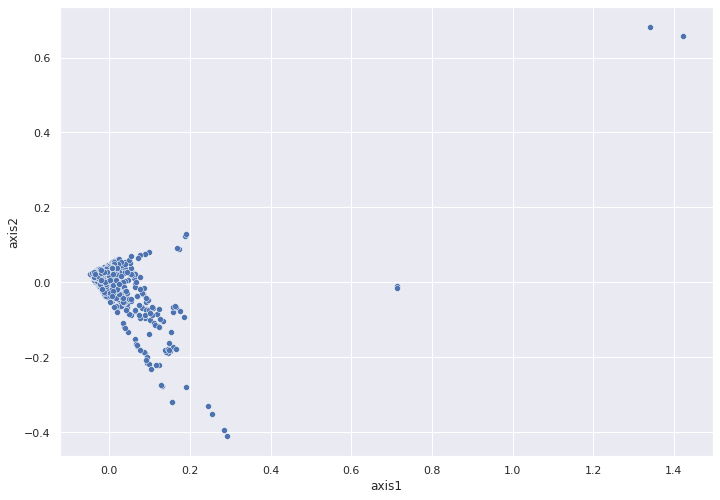

In [263]:
cls = PCA(n_components=3)
pcs = cls.fit_transform(racequant)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3"])
X.index = racequant.index
#X = pd.concat([X, join.age_range], axis=1)


sns.scatterplot(x = "axis1", y = "axis2",data = X)

In [264]:
cls.explained_variance_ratio_

array([0.61417714, 0.34276176, 0.04245808])

In [265]:
cls.components_

array([[ 8.67022801e-01,  6.15764695e-02,  4.24722464e-01,
         2.53088748e-01, -2.57435982e-06, -5.34246586e-06,
        -1.67016385e-05, -1.60555456e-06, -1.54290787e-06,
        -3.70685598e-06, -4.54479254e-06, -4.93061903e-06,
         6.96499440e-07, -3.65310644e-06, -2.21873266e-05,
        -4.57399429e-06, -1.10709374e-06, -3.94145877e-06,
        -1.95508390e-06,  4.71945916e-05, -5.49732626e-07,
         3.41857019e-06, -4.96321829e-07,  1.63995634e-05,
         9.36021934e-06, -5.05406218e-06, -7.41715001e-06,
        -1.06218617e-05, -2.51090078e-06, -4.34111885e-07,
         1.80535587e-03, -5.92496717e-06, -2.15672156e-06,
         2.25989191e-06, -1.01079141e-05, -5.46621863e-06,
        -1.83666896e-07, -2.81158961e-06, -2.73884624e-06,
        -2.14368170e-07, -2.48135479e-06, -3.80255795e-06,
        -5.58185986e-06,  3.19088902e-06, -4.29856389e-06,
        -3.94712289e-06, -9.30624345e-06, -6.98442730e-07,
         8.53338839e-04, -7.85185050e-07, -7.77681218e-0

In [266]:
len(labels)

1126

In [357]:
race = race.assign(
    part = labels
)

In [358]:
race

,race_year_id,event,race,country,participation,distance,elevation_gain,elevation_loss,aid_stations,participants,year,month,day,frequency_in_ranking,give_up,difficulty,part
0,68140,Peak District Ultras,Millstone 100,United Kingdom,solo,166.9,4520.0,-4520.0,10,150,2021,9,3,25,125,21.967032,0
1,72496,UTMB®,UTMB®,France,solo,170.7,9930.0,-9930.0,11,2300,2021,8,27,1526,774,102.024140,1
2,69855,Grand Raid des Pyrénées,Ultra Tour 160,France,solo,167.0,9980.0,-9980.0,13,600,2021,8,20,455,145,102.961609,1
3,67856,Persenk Ultra,PERSENK ULTRA,Bulgaria,solo,164.0,7490.0,-7500.0,13,150,2021,8,20,55,95,58.583716,1
4,70469,Runfire Salt Lake Ultra,100 Mile,Turkey,solo,159.9,100.0,-100.0,12,13,2021,8,20,13,0,0.067548,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,2320,Centurion Thames Path 100,Centurion Thames Path 100,United Kingdom,solo,161.0,1600.0,-1600.0,0,114,2012,3,3,114,0,3.101121,2
1203,3439,RUN2KILL,RUN2KILL,Germany,solo,161.0,4000.0,-4000.0,0,15,2012,2,24,15,0,17.313921,2
1204,5640,IRON HORSE Endurance RunS,IRON HORSE 100M,United States,solo,161.0,2400.0,-2400.0,0,25,2012,2,10,25,0,6.558721,2
1205,3202,Rocky Raccoon,100 Mile,United States,solo,161.0,1800.0,-1800.0,0,218,2012,2,4,218,0,3.845521,2


In [269]:
race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1126 entries, 0 to 1206
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   race_year_id          1126 non-null   int64  
 1   event                 1126 non-null   object 
 2   race                  1126 non-null   object 
 3   country               1126 non-null   object 
 4   participation         1126 non-null   object 
 5   distance              1126 non-null   float64
 6   elevation_gain        1126 non-null   float64
 7   elevation_loss        1126 non-null   float64
 8   aid_stations          1126 non-null   int64  
 9   participants          1126 non-null   int64  
 10  year                  1126 non-null   int64  
 11  month                 1126 non-null   int64  
 12  day                   1126 non-null   int64  
 13  frequency_in_ranking  1126 non-null   int64  
 14  give_up               1126 non-null   int64  
 15  difficulty           

<AxesSubplot:>

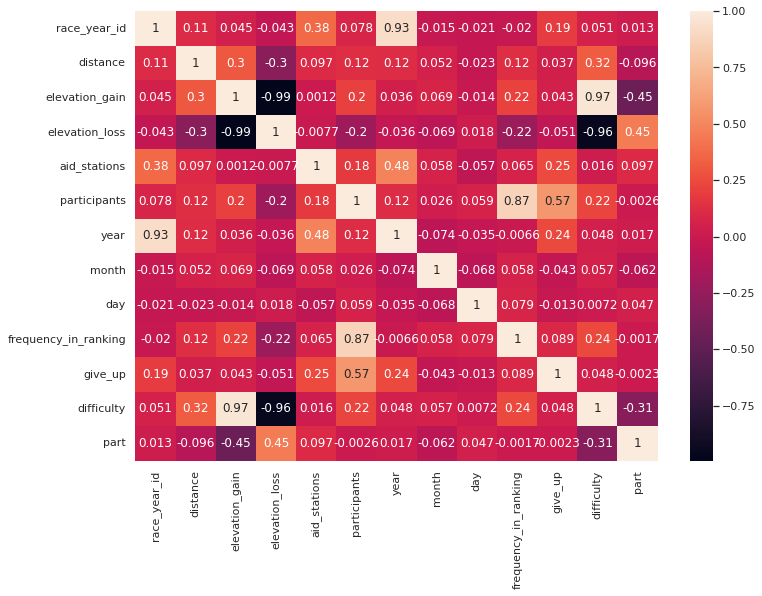

In [359]:
sns.heatmap(race.corr(), annot=True)

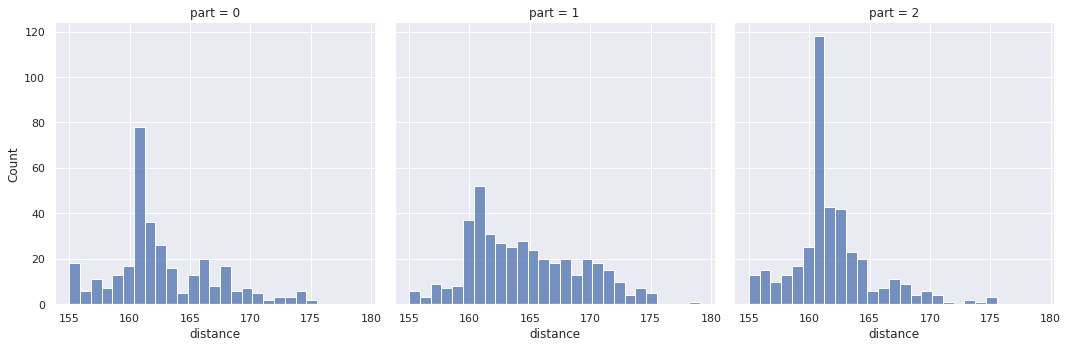

In [368]:
sns.displot(
    x = "distance",
    col = "part",
    data = race
)

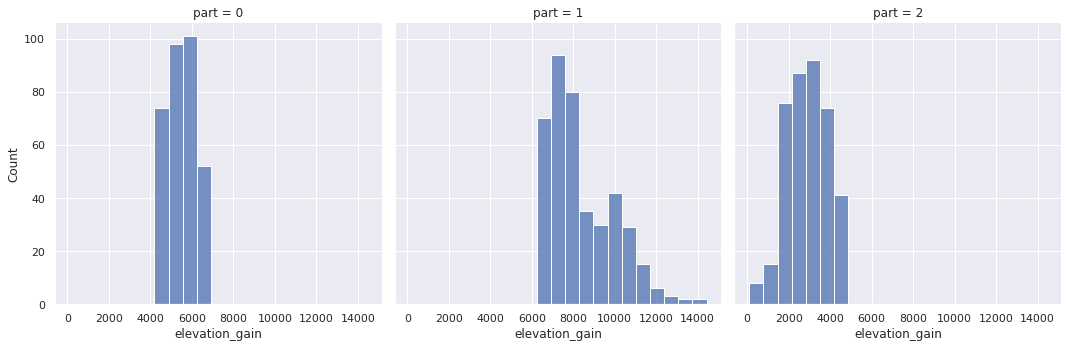

In [369]:
sns.displot(
    x = "elevation_gain",
    col = "part",
    data = race
)

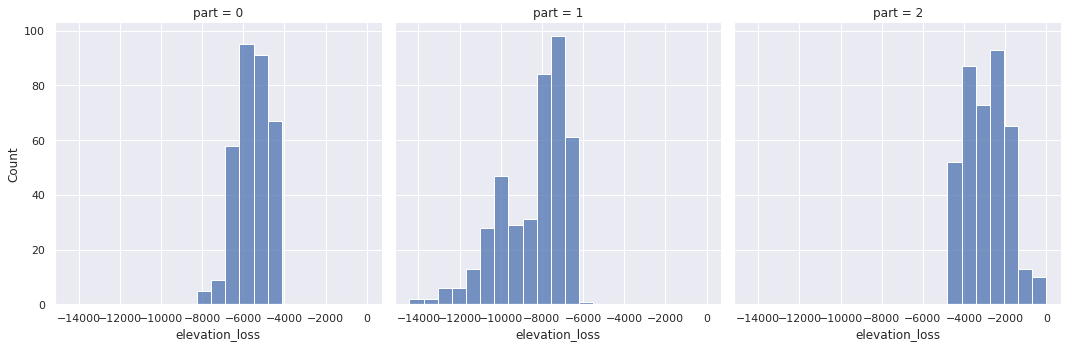

In [362]:
sns.displot(
    x = "elevation_loss",
    col = "part",
    data = race
)

<AxesSubplot:xlabel='elevation_gain', ylabel='Count'>

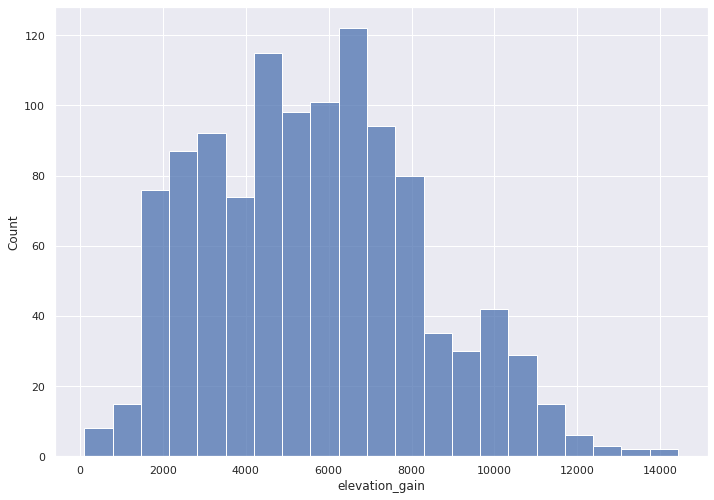

In [273]:
sns.histplot(
    x = "elevation_gain",
    data = race
)

In [370]:
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.speed < 20]
join = join.loc[join.distance > 150]
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112057 entries, 0 to 130136
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   race_year_id          112057 non-null  int64  
 1   ranking               112057 non-null  float64
 2   runner                112057 non-null  object 
 3   time                  112057 non-null  object 
 4   gender                112032 non-null  object 
 5   nationality           112057 non-null  object 
 6   time_in_seconds       112057 non-null  float64
 7   speed                 112057 non-null  float64
 8   runner_id             112032 non-null  object 
 9   age_course            110748 non-null  float64
 10  age_range             112057 non-null  object 
 11  event                 112057 non-null  object 
 12  race                  112057 non-null  object 
 13  country               112057 non-null  object 
 14  participation         112057 non-null  object 
 15  

<AxesSubplot:xlabel='part', ylabel='age_course'>

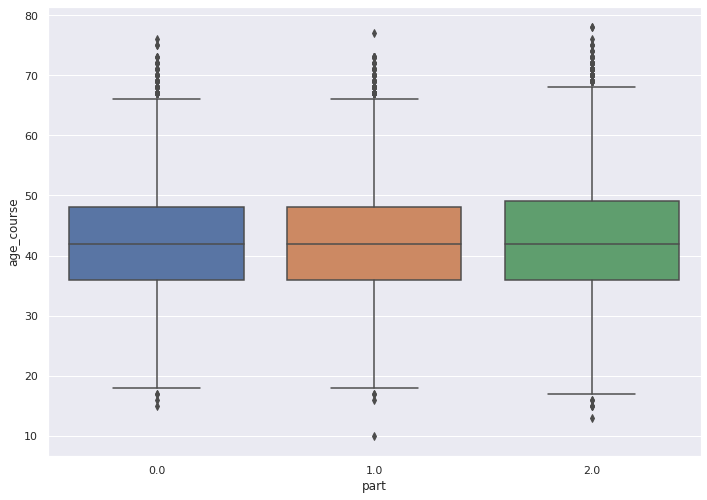

In [371]:
sns.boxplot(
    y = "age_course",
    data = join,
    x = "part"
)

<AxesSubplot:xlabel='part', ylabel='speed'>

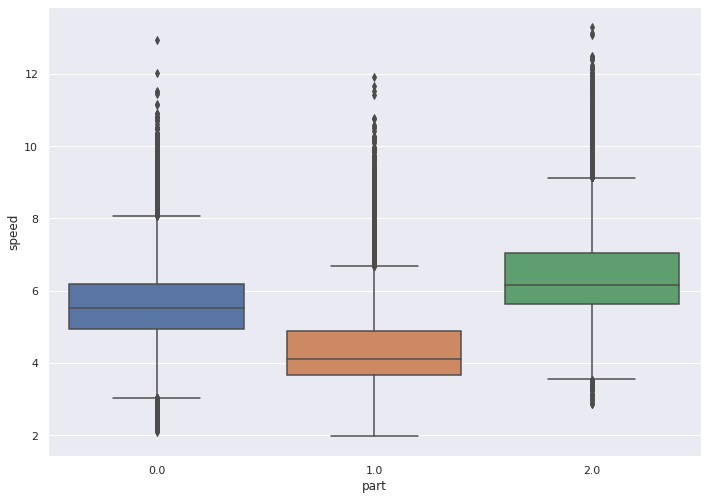

In [372]:
sns.boxplot(
    y = "speed",
    data = join,
    x = "part"
)

<AxesSubplot:xlabel='part', ylabel='participants'>

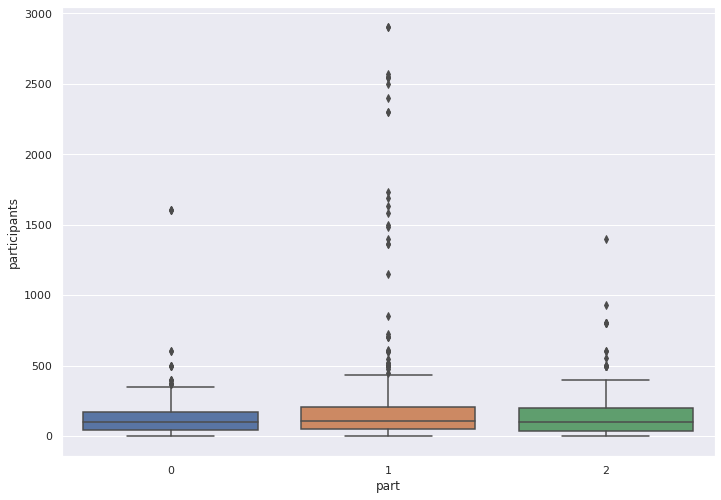

In [373]:
sns.boxplot(
    y = "participants",
    data = race,
    x = "part"
)

<AxesSubplot:xlabel='count', ylabel='country'>

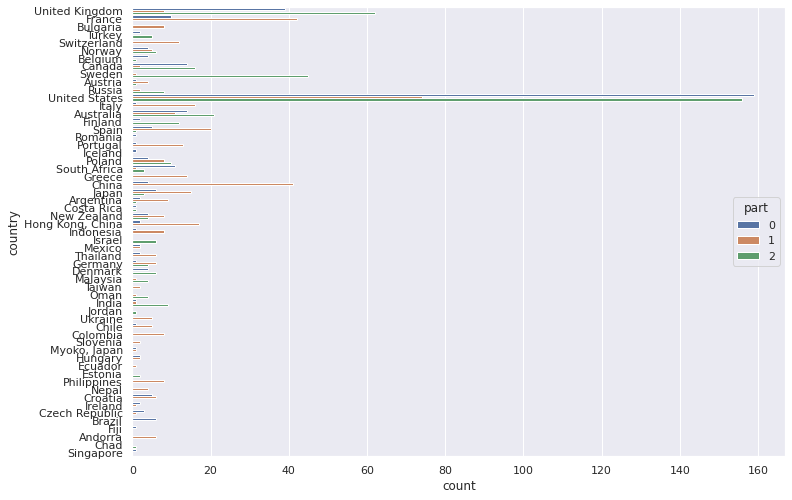

In [374]:
sns.countplot(
    y = "country",
    data = race,
    hue = "part"
)

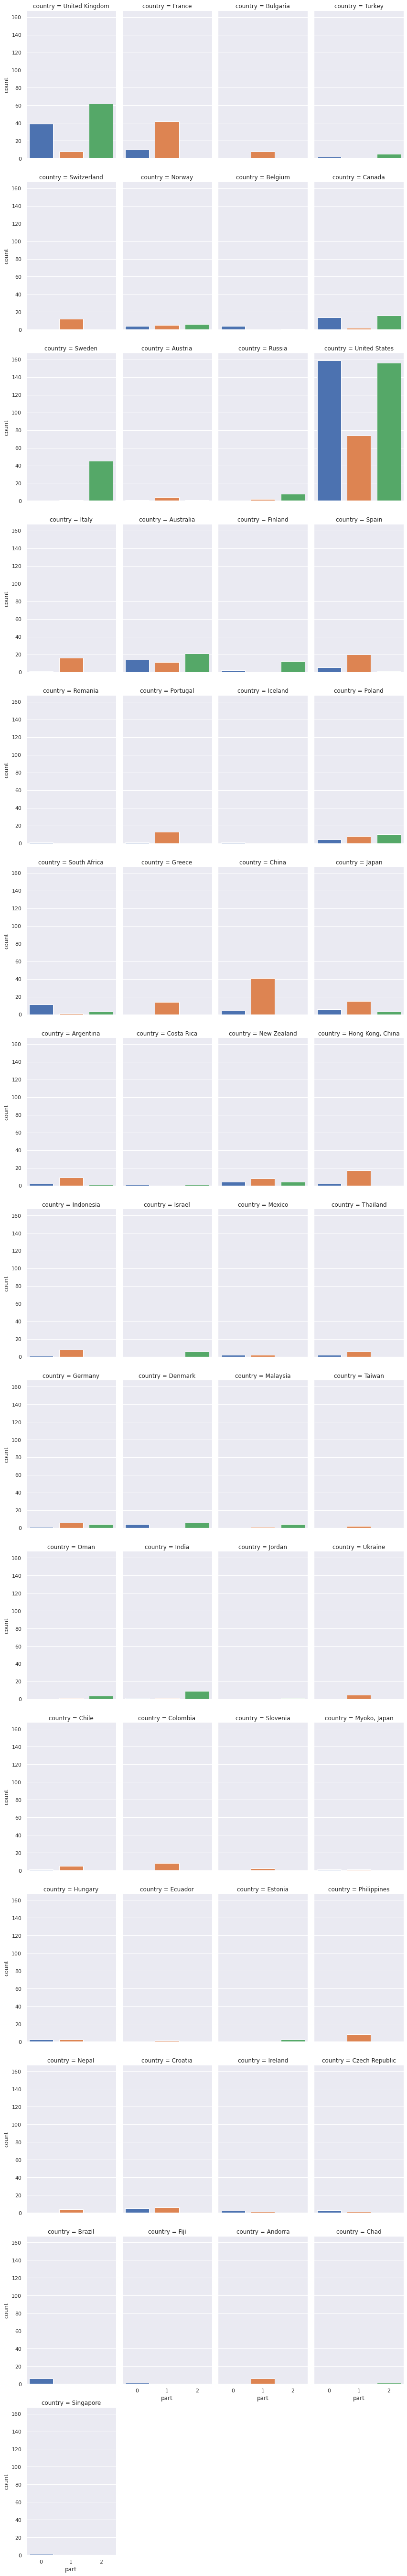

In [375]:
g = sns.catplot(x="part", col="country", col_wrap=4,

                data=race, saturation=1,

                kind="count", ci=None, aspect=.6)

<AxesSubplot:>

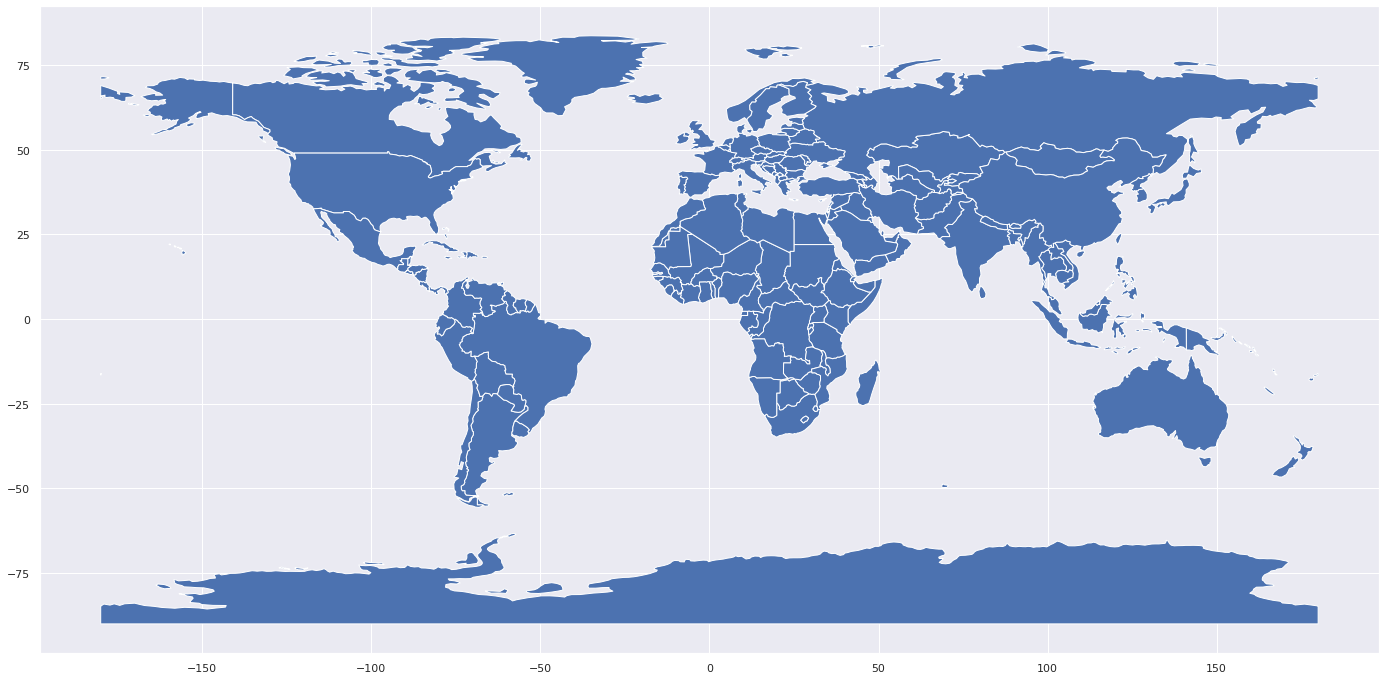

In [172]:
import geopandas
sns.set(rc={'figure.figsize':(24,32)})
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot()

In [183]:
import pycountry 
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE# create a column for code 

race['CODE']=alpha3code(race.country)

In [185]:
map_df = race
map_df = map_df.assign(
    part_avg = race.part.value_counts()
)

In [205]:
countries = race.CODE.unique()
t_df = pd.DataFrame({'CODE':countries})
avg_part = []
for c in countries:
    somme = race.loc[race.CODE == c].part.sum()
    avg_part.append(somme / len(race.loc[race.CODE == c]))

t_df = t_df.assign(
    avg_part = avg_part
)
t_df

,CODE,avg_part
0,GBR,0.073394
1,FRA,0.807692
2,BGR,1.000000
3,TUR,0.000000
4,CHE,1.000000
5,NOR,0.333333
6,BEL,0.000000
7,CAN,0.062500
8,SWE,0.021739
9,AUT,0.666667


In [236]:
# first let us merge geopandas data with our data
# 'naturalearth_lowres' is geopandas datasets so we can use it directly
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))# rename the columns so that we can merge with our data
world.loc[world.name == "France", "CODE"] = "FRA"
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']# then merge with our data 
merge=pd.merge(world,t_df,on='CODE')# last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude

ValueError: Length mismatch: Expected axis has 7 elements, new values have 6 elements

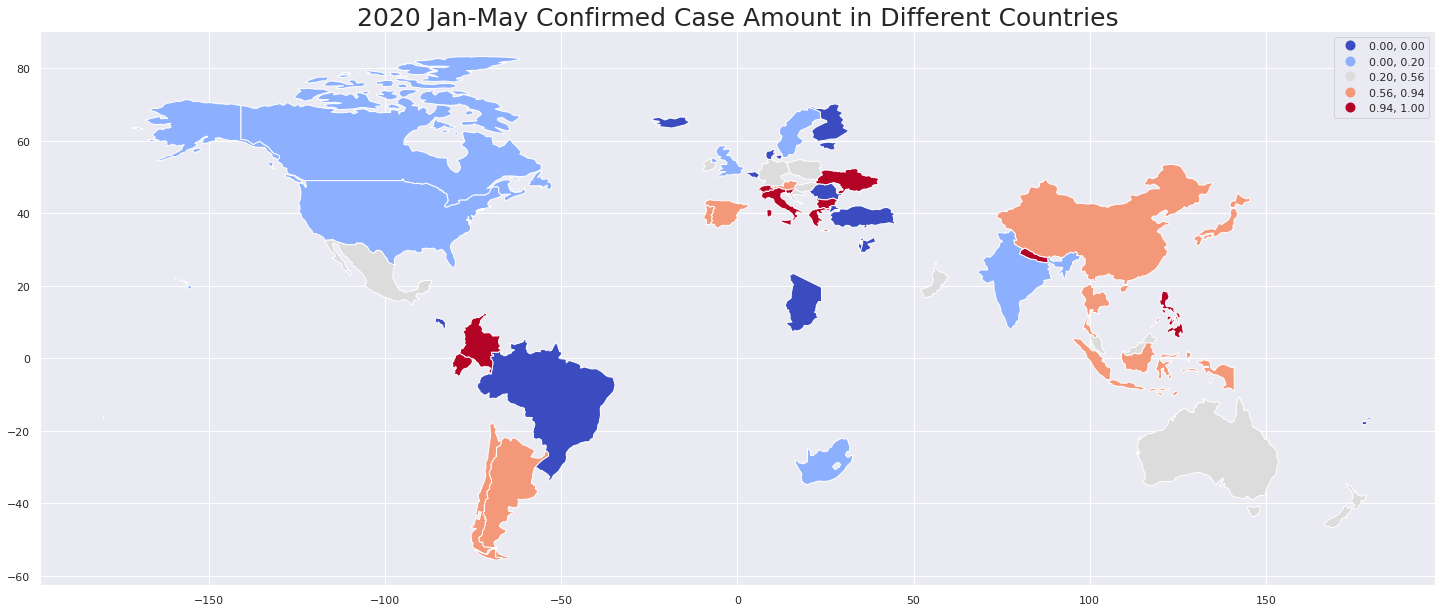

In [220]:
# plot confirmed cases world map 
merge.plot(column='avg_part', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap='coolwarm')
plt.title('2020 Jan-May Confirmed Case Amount in Different Countries',fontsize=25)# add countries names and numbers 
for i in range(0,10):
    plt.show()

In [235]:
world.loc[world.name == "France"]

,pop_est,continent,name,CODE,gdp_md_est,geometry
43,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3..."


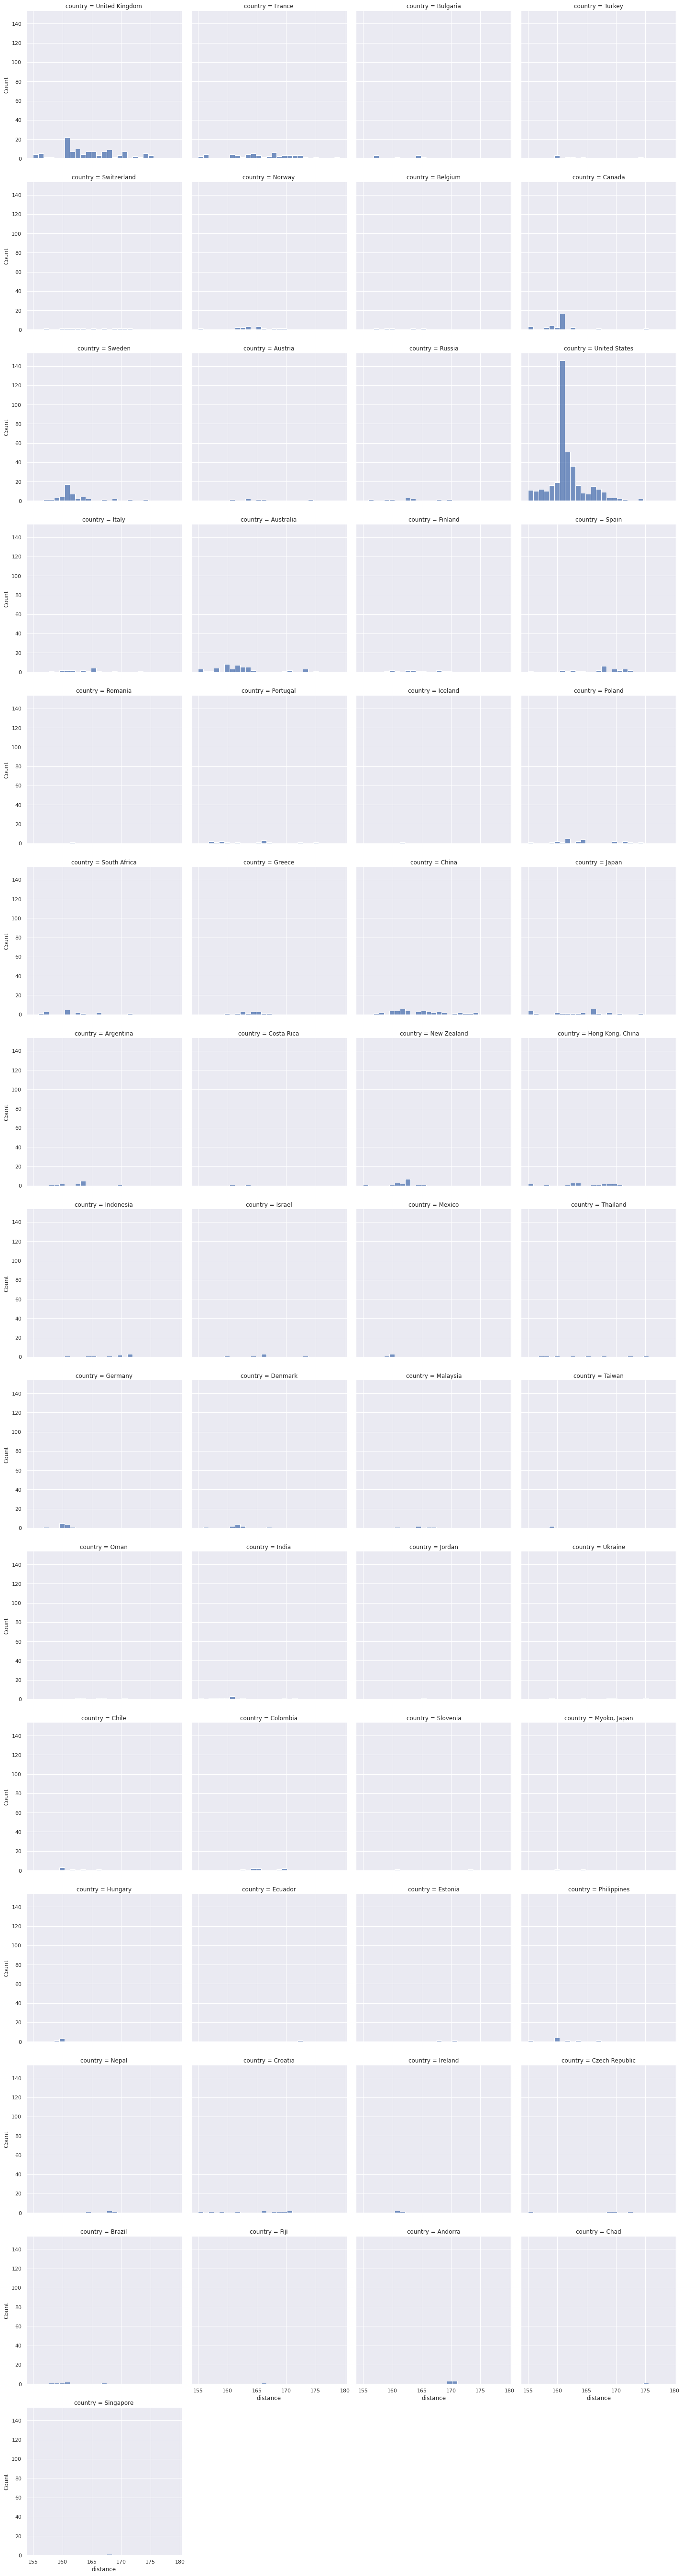

In [277]:
g = sns.displot(x="distance", col="country", col_wrap=4,

                data=race
)

<AxesSubplot:xlabel='distance', ylabel='country'>

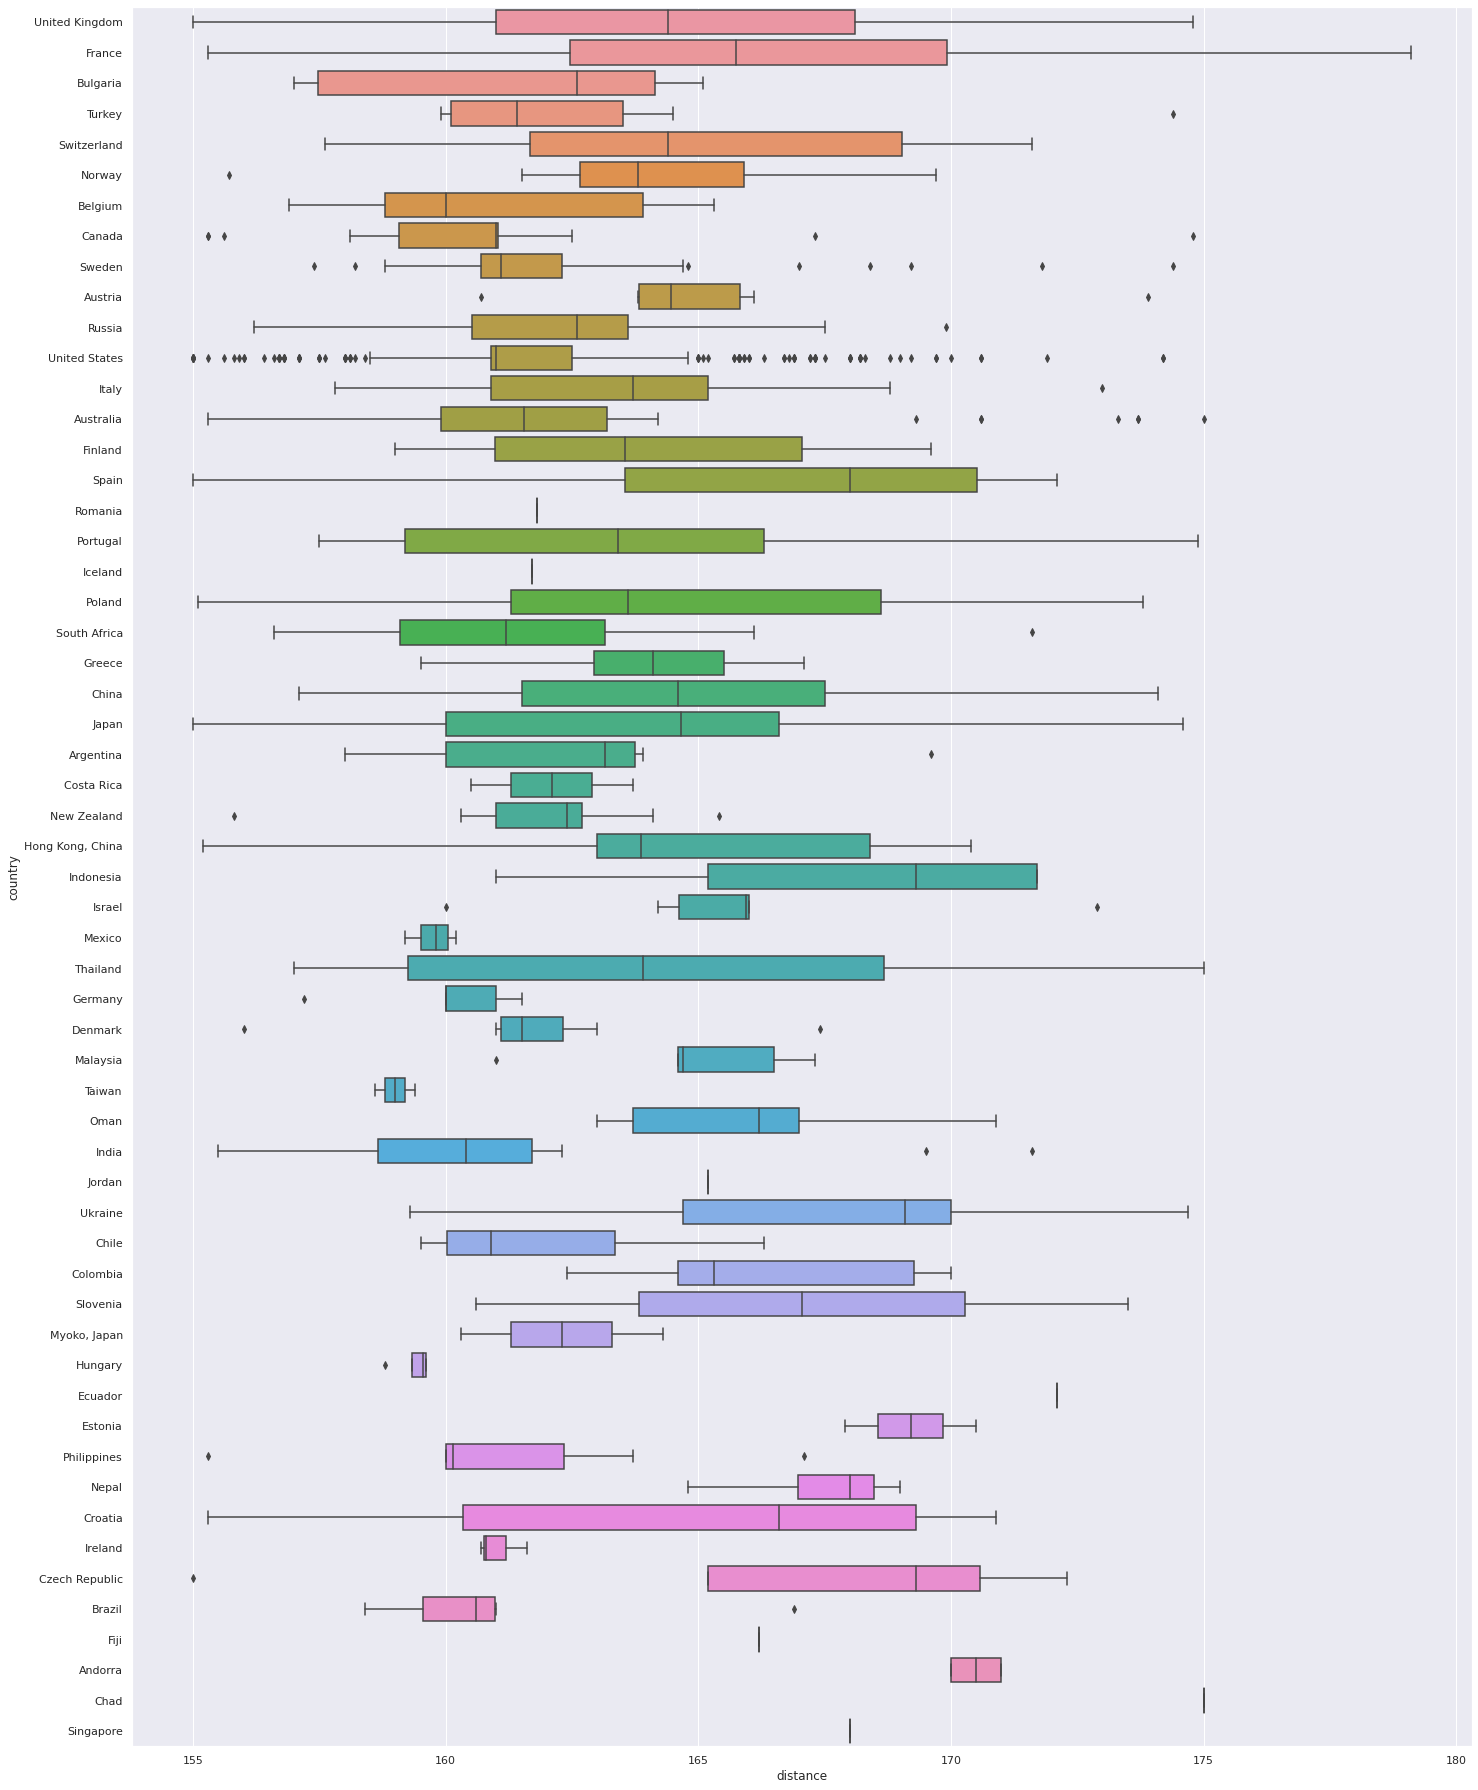

In [280]:
sns.set(rc={'figure.figsize':(24,32)})

sns.boxplot(x='distance', y='country', data=race)

<AxesSubplot:xlabel='distance', ylabel='Count'>

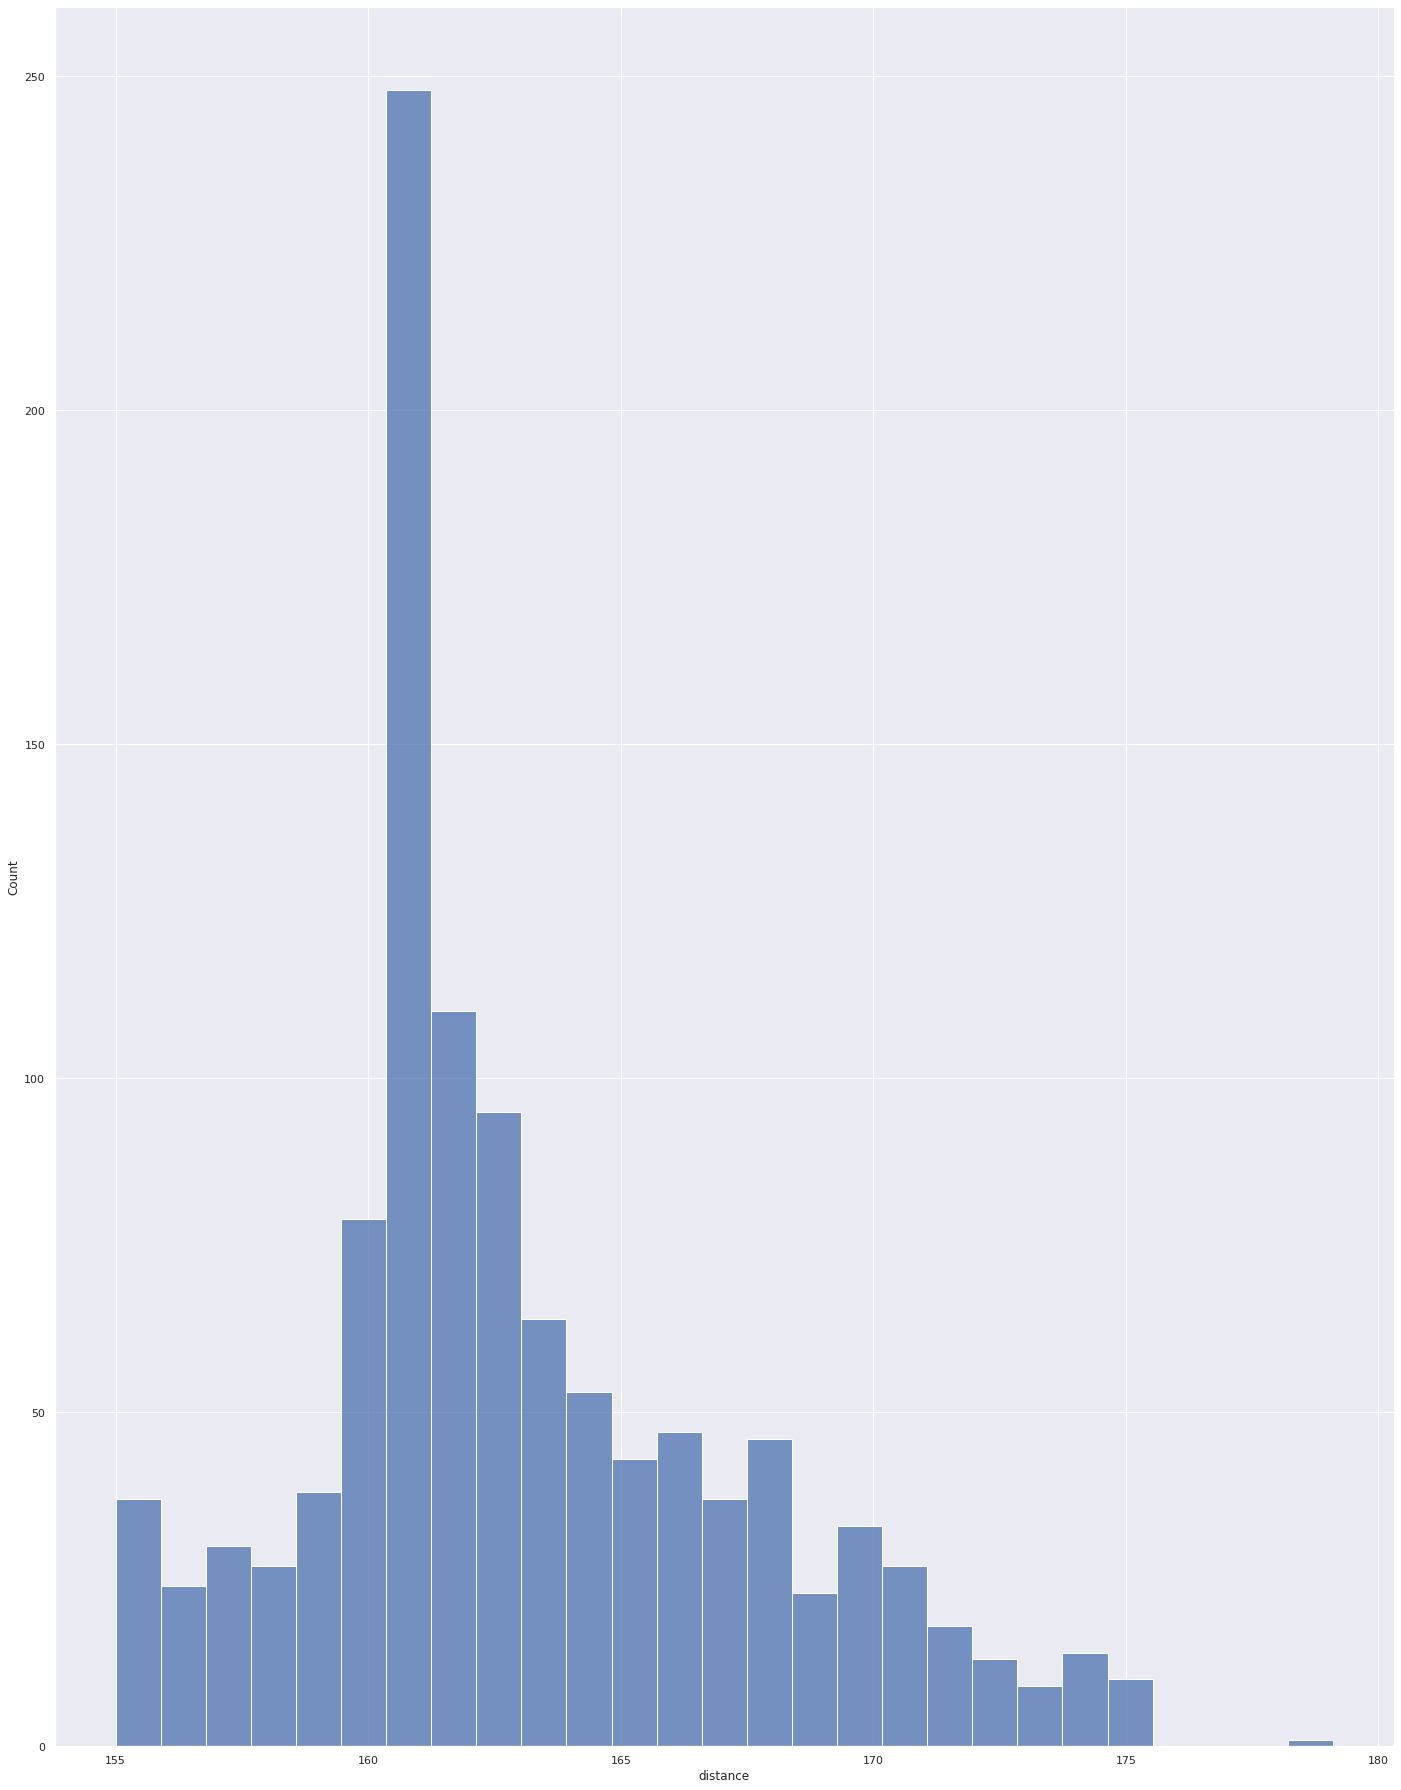

In [281]:
sns.histplot(
    x  = race.distance
)

In [295]:
racequant = race[['distance','elevation_gain','aid_stations','participants','frequency_in_ranking']]
l_eg = race['elevation_gain']


# ONE HOT ENCODING

#racequant = racequant.apply(lambda x: x-x.mean())
racequant_no_elevation = racequant.drop(columns=['elevation_gain'])

In [296]:
X = pd.DataFrame(
    squareform(pdist(racequant_no_elevation)),
    columns = race.race_year_id,
    index = race.race_year_id
)
n,p = X.shape
Qn = np.eye(n) - 1/n * np.ones((n,n),dtype=int)
Qp = np.eye(p) - 1/p * np.ones((p,p),dtype=int)

Xprime = Qn @ X @ Qp
Xprime

,0,1,2,3,4,5,6,7,8,9,...,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125
0,-108.488097,137.288132,76.311547,-70.260524,11.812963,-31.322410,11.935772,-53.791472,-29.423831,-53.008168,...,8.037980,9.638219,10.115532,12.069455,11.812830,-3.030598,12.053481,11.646260,33.035496,6.733856
1,137.288132,-4861.176838,-913.211402,128.176363,239.950542,-74.278126,236.776269,60.343555,147.002678,190.170458,...,58.819056,228.529919,229.967402,237.977656,240.229974,126.333595,239.287625,235.353852,-89.445460,220.160556
2,76.311547,-913.211402,-983.732591,63.915655,171.309929,-117.193934,168.013354,-0.859113,78.896252,127.229923,...,-11.311720,159.652623,161.117618,169.337996,171.709981,56.512754,170.705048,166.629371,-159.769320,151.147653
3,-70.260524,128.176363,63.915655,-92.610506,25.390194,-25.543172,23.936370,-59.994262,-45.331911,-28.482877,...,-13.629038,18.800527,19.765918,24.867991,25.951937,-21.404798,25.557356,23.287060,13.134827,13.178055
4,11.812963,239.950542,171.309929,25.390194,-143.320181,88.340107,-116.377649,57.749611,16.184100,-38.324157,...,59.205494,-88.207012,-92.176908,-122.258874,-133.504539,26.191583,-128.851641,-110.494167,100.825494,-69.214920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,-3.030598,126.333595,56.512754,-21.404798,26.191583,22.395140,22.357558,-13.184169,-46.949374,13.752881,...,-57.835671,13.583113,15.078844,23.522153,26.002441,-90.982613,24.946483,20.725927,-16.091620,4.920698
1122,12.053481,239.287625,170.705048,25.557356,-128.851641,88.574816,-117.859179,57.468025,16.212146,-35.664464,...,58.093424,-91.105108,-95.266231,-129.249329,-137.998473,24.946483,-139.138707,-115.074992,99.837475,-71.483251
1123,11.646260,235.353852,166.629371,23.287060,-110.494167,87.505009,-114.229252,55.165600,12.502236,-33.135933,...,53.872869,-95.325663,-99.486786,-116.499321,-113.997227,20.725927,-115.074992,-119.295547,95.616920,-75.703807
1124,33.035496,-89.445460,-159.769320,13.134827,100.825494,-59.521179,97.180559,-31.955790,13.680649,73.658512,...,-84.768055,88.474105,89.969836,98.413145,100.891709,-16.091620,99.837475,95.616920,-235.357049,79.811690


In [313]:
cls = AgglomerativeClustering(linkage="ward", affinity="euclidean",  n_clusters=2)
cls.fit(Xprime)

AgglomerativeClustering()

In [314]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot_dendrogram(cls)

AttributeError: 'AgglomerativeClustering' object has no attribute 'distances_'

In [299]:
cls.labels_

array([742, 911, 975, ...,   2,   1,   0])

In [301]:
print(cls.labels_)

[742 911 975 ...   2   1   0]


/home/romain/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

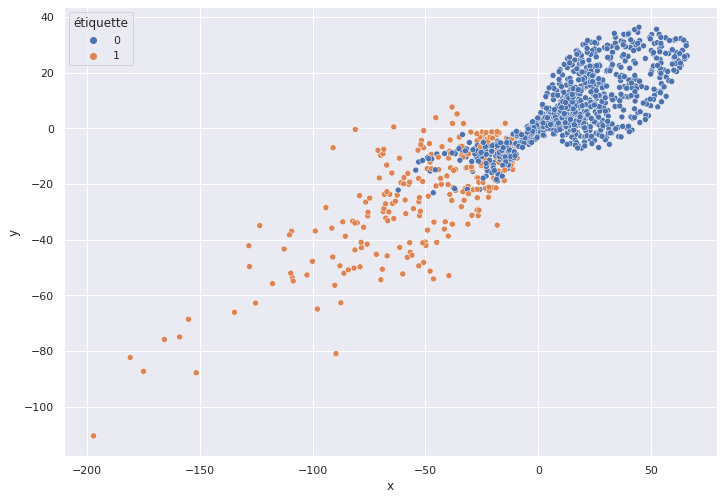

In [319]:
model = AgglomerativeClustering(
    affinity="precomputed", linkage="complete", n_clusters=2
).fit(Xprime)

labels2 = model.labels_
#labels = model.labels_

aftd = MDS(n_components=2, dissimilarity="precomputed")
dist = aftd.fit_transform(Xprime)

df = pd.DataFrame({"x": dist[:, 0], "y": dist[:, 1], "étiquette":labels})
#df = pd.DataFrame({"x": dist[:, 0], "y": dist[:, 1]})

df = df.assign(
    distance = racequant.distance,
    aid_stations = racequant.aid_stations,
    participants = racequant.participants,
    frequency_in_ranking = racequant.frequency_in_ranking,
)

sns.scatterplot("x", "y", hue='étiquette', data=df)
#add_labels(dist[:, 0], dist[:, 1], X.index)

In [320]:
race = race.assign(
    part2 = labels2
)

<AxesSubplot:>

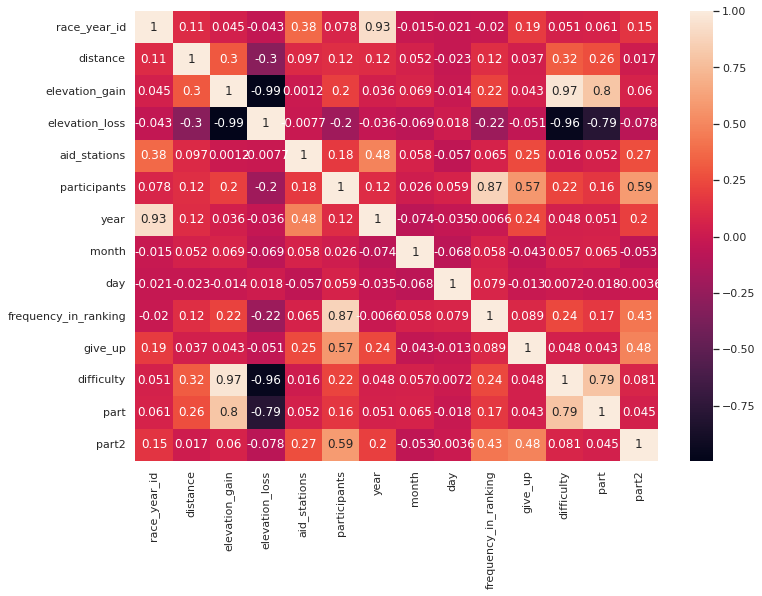

In [323]:
sns.heatmap(race.corr(), annot=True)

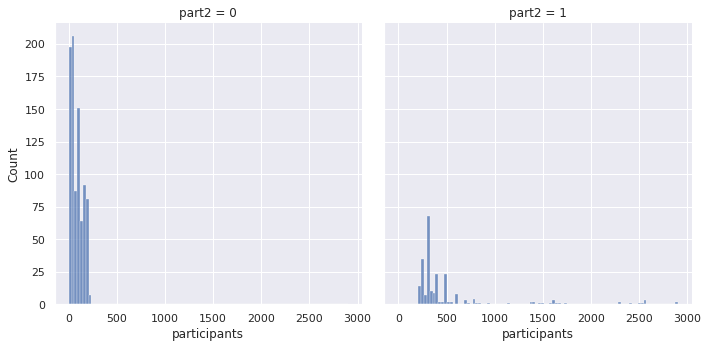

In [331]:
sns.displot(
    x = "participants",
    col = "part2",
    data = race
    
)